In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import tqdm

In [2]:
from photonics.sim import *
from photonics.demix import *

Connecting dimitri@localhost:3306


In [3]:
DSim()

dsim,dsim_description,detector_type choice in simulation,detector_width (um) along x-axis,detector_height (um) along y-axis,anisotropy factor in the Henyey-Greenstein formula,absorption_length (um) average travel path before a absoprtion event,scatter_length (um) average travel path before a scatter event,volume_dimx (voxels),volume_dimy (voxels),volume_dimz (voxels),pitch (um) spatial sampling period of the model volume
0,100% Efficient Lambertian 10x50 rect,one-sided,10.00,50.00,0.88,14000.0,100.0,1000,1000,1000,2.2
1,100% Efficient Lambertian 10x20 rect,one-sided,10.00,20.00,0.88,14000.0,100.0,1000,1000,1000,2.2
2,"Narrow selective as 4th power of cosine, 10x10 rect",narrowed,10.00,20.00,0.88,14000.0,100.0,1000,1000,1000,2.2
3,"Narrow selective as 2th power of cosine, 10x20 rect",narrowed2,10.00,20.00,0.88,14000.0,100.0,1000,1000,1000,2.2
4,"Narrow selective as 8th power of cosine, 10x20 rect",narrowed8,10.00,20.00,0.88,14000.0,100.0,1000,1000,1000,2.2


In [4]:
SpikeSNR.populate()
Cosine.populate()

100%|██████████| 5/5 [01:29<00:00, 17.94s/it]


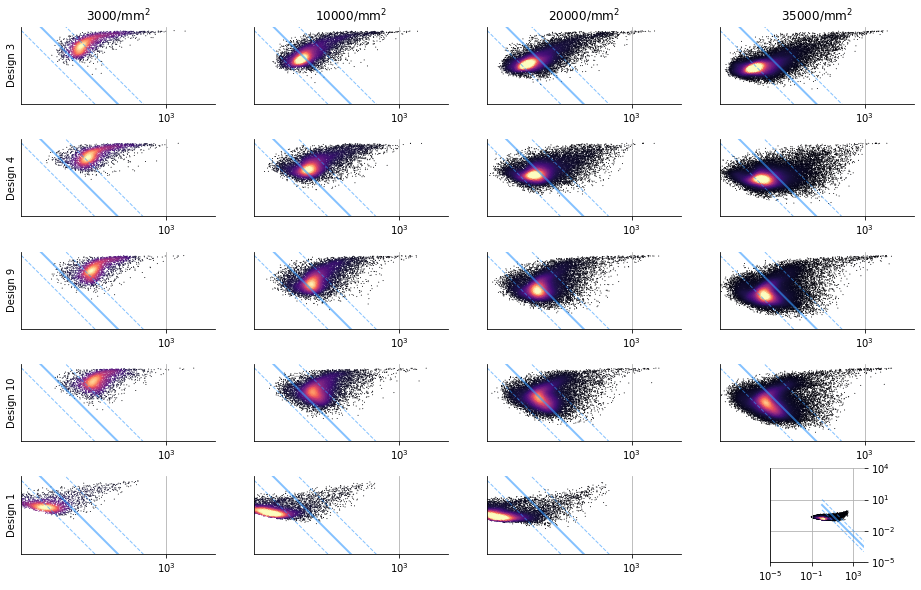

In [6]:
fig, axx = plt.subplots(5, 4, figsize=(16, 10), sharex=True, sharey=True)
axx = iter(axx.flatten())

designs = [3, 4, 9, 10, 1]
samples = [1, 3, 4, 5]
for design in tqdm.tqdm(designs):
    for sample in samples:
        ax = next(axx)
        key = dict(design=design, sample=sample)
        
        if not SpikeSNR & key:
            ax.axis(False)
            continue
        snrs, cosines, density = (SpikeSNR * Cosine * Sample & key).fetch1(
            'snr', 'cosines', 'density')
        
        selection, xyz = (Demix*Tissue & key).fetch1('selection', 'cell_xyz')
        xyz = xyz[selection]
        dxyz = np.stack((Geometry.Detector & key).fetch('d_center_x', 'd_center_y', 'd_center_z')).T
        ix = (np.logical_and(xyz > dxyz.min(axis=0), xyz < dxyz.max(axis=0))).any(axis=1)
        cos = np.maximum(cosines[ix], 0.0009)
        snr = np.maximum(snrs[ix], 0.01);
        xy = np.vstack([np.log10(snr/cos)/4, np.log10(cos)*4])
        z = gaussian_kde(xy)(xy)
        h = ax.scatter(snr/cos, cos, c=z, s=1, marker='o', lw=0, cmap='magma')
        h.set_clim([0, 5.0])
        ax.plot([1, 10000], [3, 3/10000], color=[0.2, 0.6, 1.0], linewidth=2, alpha=0.6, ls='-')
        ax.plot([1, 10000], [1, 1/10000], color=[0.2, 0.6, 1.0], linewidth=1, alpha=0.6, ls='--')
        ax.plot([1, 10000], [10, 10/10000], color=[0.2, 0.6, 1.0], linewidth=1, alpha=0.6, ls='--')
        ax.set_xlim([1.0, 1.05e4])
        ax.set_ylim([0.03, 1.2])
        ax.set_xticks(10. ** np.r_[-5:1])
        ax.set_yticks(10. ** np.r_[-5:5])
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_aspect('equal')
        ax.yaxis.set_ticks_position('right')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.grid(True)
        ax.set_frame_on(True)
        if design == designs[0]:
            ax.set_title('{density}/mm$^2$'.format(density=density))
        if design < designs[-1]:
            plt.setp(ax.get_xticklabels(), visible=False)
        if sample == samples[0]:
            ax.set_ylabel(f'Design {design}')
        if sample < samples[-1]:
            plt.setp(ax.get_yticklabels(), visible=False)
#fig.savefig('results.pdf')

In [ ]:
!open results.png

In [ ]:
key = {'design': 8, 'sample': 4}

In [ ]:
!open results.pdf

In [ ]:
ls -l results.pdf

In [ ]:
Geometry.Detector()

In [ ]:
ax.grid()

In [ ]:
schema.spawn_missing_classes()

In [ ]:
dj.Diagram(schema)

In [ ]:
Fluorescence()

In [ ]:
Sample * Cosine * SpikeSNR

In [ ]:
dj.kill()

In [ ]:
(schema.jobs & 'status="error"').delete()

In [ ]:
IlluminationCycle()

In [ ]:
Cosine()

In [ ]:
dj.U('design') & Cosine

In [ ]:
for design in 1,3,4,5,6,7,8:
    selection, density, cosines, snr, xyz = (
        Demix * Tissue * Sample * Cosine * SpikeSNR & {'design': design}).fetch(
        'selection', 'density', 'cosines', 'snr', 'cell_xyz')
    #plt.plot(density, 
    #         [(m[np.abs(xyz[s, :] - [0, 0, 500]).max(axis=1) < 400]).mean() for s, m, xyz in zip(selection, snr, xyz)], 'x-')
    plt.plot(density, 
             [(m[np.abs(xyz[s, :] - [0, 0, 200]).max(axis=1) < 200]).mean() for s, m, xyz in zip(selection, cosines, xyz)], 'x-')
plt.ylim([0, 1])
plt.legend(('1', '3', '4', '5', '6', '7', '8'))
plt.grid(True)

In [ ]:
r = 'design=4'

In [ ]:
e = (Fluorescence.Emitter & r).fetch('reemitted_photons')
d = (Detection.Detector & r).fetch('detect_probabilities')

In [ ]:
e = np.stack(e)
d = np.stack(d)

In [ ]:
cycle = (IlluminationCycle & r).fetch1('illumination')

In [ ]:
selection = (Demix & r & 'sample=4').fetch1('selection')

In [ ]:
e = cycle @ e

In [ ]:
e = e[:, selection]
d = d[:, selection]

In [ ]:
plt.scatter(np.log10(e.sum(axis=0)*0.0001), np.log10(d.sum(axis=0)), s=1)

In [ ]:
plt.hist(np.log10(e.sum(axis=0)*1e-4*d.sum(axis=0)), 100);

In [ ]:
key = {'design':4, 'sample': 4}

In [ ]:
        dt = 0.02   # (s) sample duration (one illumination cycle)
        power = 1e-4   # 100 uW
        dark_noise = 300  # counts per second
        seed = 0

        # load the emission and detection matrices
        npoints, volume = (Tissue & key).fetch1('npoints', 'volume')
        target_density = (Sample & key).fetch1('density')

        selection = np.r_[:npoints] < int(np.round(target_density) * volume)
        np.random.seed(seed)
        np.random.shuffle(selection)

In [ ]:
        illumination = (IlluminationCycle & key).fetch1('illumination')
        nframes = illumination.shape[0]
        illumination = illumination * power / nframes   

In [ ]:
        emission = np.stack(
            [np.float32(x[selection]) 
             for x in (Fluorescence.Emitter & key).fetch('reemitted_photons')])  #  emitters x sources
        emission = dt * illumination @ emission  # photons per frame

        detection = np.stack(
            [np.float32(x[selection]) 
             for x in (Detection.Detector & key).fetch('detect_probabilities')])   #  detectors x sources

In [ ]:
        # construct the mixing matrix mix: nchannels x ncells
        # mix = number of photons from neuron per frame at full fluorescence
        ncells = detection.shape[1]
        ndetectors = detection.shape[0]
        nchannels = nframes * ndetectors
        mix = np.ndarray(dtype='float32', shape=(nchannels, ncells))
        for ichannel in range(0, nchannels, ndetectors):
            mix[ichannel:ichannel + ndetectors] = detection * emission[ichannel//ndetectors] 

In [ ]:
plt.hist(np.log10(mix.sum(axis=0)/dt), 100);
plt.xlabel('$log_{10}$ photons/s') 
plt.ylabel(' cells')
plt.xlim([0, 6])

In [ ]:
        # normalize channels by their noise
        mean_fluorescence = 0.03
        nu = dark_noise * dt / nframes
        weights = 1/np.sqrt(mix.sum(axis=1, keepdims=True)*mean_fluorescence + nu)  # used to be axis=0
        mix *= weights

In [ ]:
plt.hist(weights, 100);

In [ ]:
# normalization
kmax = 1e6
square = mix.T @ mix
identity = np.identity(mix.shape[1])
alpha = np.sqrt(scipy.linalg.eigh(
    square, eigvals_only=True, eigvals=(ncells-1, ncells-1))[0])/(2*kmax)
square += alpha**2 * identity

# demix matrix 
demix = np.linalg.inv(square) @ mix.T

# bias matrix
bias = demix @ mix - identity

In [ ]:
mix_norm = np.linalg.norm(mix, axis=0)
demix_norm = np.linalg.norm(demix, axis=1)
bias_norm = np.linalg.norm(bias, axis=1)

In [ ]:
max_bias = 0.01
delta = 0.1
tau = 0.8
dt = 0.02  # must match the one in Demix
rho = np.exp(-2*np.r_[0:6*tau:dt]/tau).sum()   # SNR improvement by matched filter
snrs = (bias_norm < max_bias) * rho * delta / demix_norm

In [ ]:
max_bias = 0.01
cosines = (bias_norm < max_bias) / (mix_norm * demix_norm)

In [ ]:
plt.hist(np.log10(snr), 100);

In [ ]:
from scipy.stats import gaussian_kde
cos = np.maximum(cosines, 0.0009)
snr = np.maximum(snrs*3, 0.09)
xy = np.vstack([np.log10(snr/cos)/4, np.log10(cos)*4])
z = gaussian_kde(xy)(xy)
print(z.max())
h = plt.scatter(snr/cos, cos, c=z, s=6, marker='o', lw=0, cmap='plasma', alpha=0.2)
h.set_clim([0, 2.3])
plt.plot([1, 10000], [3, 3/10000], color=[0.2, 0.6, 1.0], linewidth=2, alpha=0.6, ls='-')
plt.plot([1, 10000], [1, 1/10000], color=[0.2, 0.6, 1.0], linewidth=1.5, alpha=0.6, ls='--')
plt.plot([1, 10000], [10, 10/10000], color=[0.2, 0.6, 1.0], linewidth=1.5, alpha=0.6, ls='--')
plt.xticks(10 * np.r_[-5:1])
plt.yticks(10 * np.r_[-5:5])
plt.xlim([1.0, 1.05e4])
plt.ylim([0.003, 1.2])
plt.axes().set_yscale('log')
plt.axes().set_xscale('log')
plt.axes().set_aspect('equal')
plt.axes().spines['right'].set_visible(False)
plt.axes().spines['top'].set_visible(False)
plt.axes().yaxis.set_ticks_position('left')
plt.axes().xaxis.set_ticks_position('bottom')
plt.box(True)
plt.grid(True)


In [ ]:
(snr>3).mean()

In [ ]:
dj.Diagram(schema)

In [ ]:
EField()

In [ ]:
v = (DField() & 'dsim=1').fetch1('volume')

In [ ]:
plt.imshow()

In [ ]:
xyz[0][:,2].max()

In [ ]:
xyz[0].shape

In [ ]:
np.linalg(xyz[0]

In [ ]:
for design in 1, 3, 4:
    density, cosines, snr = (Sample * Cosine * SpikeSNR & {'design': design}).fetch(
        'density', 'cosines', 'snr')
    plt.plot(density, [m.mean() for m in snr])
plt.legend(('1', '3', '4'))

# Queries

In [ ]:
key = {'design': 4, 'sample': 4}

In [ ]:
power = 1e-4
dt = 0.02
npoints, volume = (Tissue & key).fetch1('npoints', 'volume')
target_density = (Sample & key).fetch1('density')

illumination = (IlluminationCycle & key).fetch1('illumination')
nframes = illumination.shape[0]
illumination = illumination * power / nframes

In [ ]:
selection, mix_norm, demix_norm, bias_norm, t_norm = (Demix & key).fetch1(
    'selection', 'mix_norm', 'demix_norm', 'bias_norm', 'trans_bias_norm')

In [ ]:
emission = np.stack((Fluorescence.Emitter & key).fetch('reemitted_photons'))[:, selection]  
emission = dt * illumination @ emission  # photons per frame
detection = np.stack((Detection.Detector & key).fetch('detect_probabilities'))[:, selection]

In [ ]:
xyz = (Tissue & key).fetch1('cell_xyz')[selection]

In [ ]:
max_bias = 0.01
delta = 0.1
tau = 0.2
dt = 0.02  # must match the one in Demix
rho = np.exp(-2*np.r_[0:6*tau:dt]/tau).sum()   # SNR improvement by matched filter
snr = (bias_norm < max_bias) * rho * delta/demix_norm

In [ ]:
(snr > 1).mean()

In [ ]:
ix = (snr < 3)
plt.scatter(emission[:,ix].sum(axis=0), snr[ix], s=1)

In [ ]:
collection = emission.sum(axis=0) * detection.sum(axis=0)

In [ ]:
collection.shape

In [ ]:
plt.hist(np.log10(collection), 100);

In [ ]:
plt.scatter(np.log10(emission.sum(axis=0)), np.log10(detection.sum(axis=0)), s=1)

In [ ]:
cosines = 1/(demix_norm * mix_norm)

In [ ]:
plt.hist(cosines, 100);

In [ ]:
plt.scatter(np.log10(collection), np.log10(cosines), s=1)

In [ ]:
(snr > 0.05).mean()

In [ ]:
plt.hist(np.log10(collection * cosines), 100);

In [ ]:
plt.scatter(np.log10(snr), np.log10(np.sqrt(collection)* cosines), s=1)
plt.grid(True)